## Install libraries

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Dataset loading and preparation

In [2]:
class PairedImageDataset(Dataset):
    def __init__(self, original_dir, retouched_dir, transform=None, num_images=None, split='train', val_ratio=0.1, test_ratio=0.1):
        self.original_dir = original_dir
        self.retouched_dir = retouched_dir
        self.transform = transform
        
        # Get list of image names and ensure the same images are in both folders
        self.original_images = sorted(os.listdir(original_dir))
        self.retouched_images = sorted(os.listdir(retouched_dir))
        self.original_images = [img for img in self.original_images if img in self.retouched_images]
        
        # Dynamically choose number of images to load
        if num_images is not None:
            self.original_images = self.original_images[:num_images]
        
        # Split the dataset into train, validation, and test sets
        train_images, test_images = train_test_split(self.original_images, test_size=test_ratio, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=val_ratio / (1 - test_ratio), random_state=42)

        if split == 'train':
            self.image_list = train_images
        elif split == 'val':
            self.image_list = val_images
        elif split == 'test':
            self.image_list = test_images
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        original_image_path = os.path.join(self.original_dir, self.image_list[idx])
        retouched_image_path = os.path.join(self.retouched_dir, self.image_list[idx])  # Same name

        original_image = Image.open(original_image_path).convert('RGB')
        retouched_image = Image.open(retouched_image_path).convert('RGB')
        
        if self.transform:
            original_image = self.transform(original_image)
            retouched_image = self.transform(retouched_image)
        
        return original_image, retouched_image

In [3]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = v2.Compose([
    v2.Resize((1024, 1024)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std),
])

In [4]:
original_dir = '/kaggle/input/original-and-retouched-faces-images-dataset/original'
retouched_dir = '/kaggle/input/original-and-retouched-faces-images-dataset/retouched'

num_images_to_load = 2000  # Set number of images to use in dataset
batch_size = 8

In [5]:
train_dataset = PairedImageDataset(original_dir,
                                   retouched_dir,
                                   transform=transform,
                                   num_images=num_images_to_load,
                                   split='train')
val_dataset = PairedImageDataset(original_dir,
                                 retouched_dir,
                                 transform=transform,
                                 num_images=num_images_to_load,
                                 split='val')
test_dataset = PairedImageDataset(original_dir,
                                  retouched_dir,
                                  transform=transform,
                                  num_images=num_images_to_load,
                                  split='test')

In [6]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [7]:
len(train_loader)

200

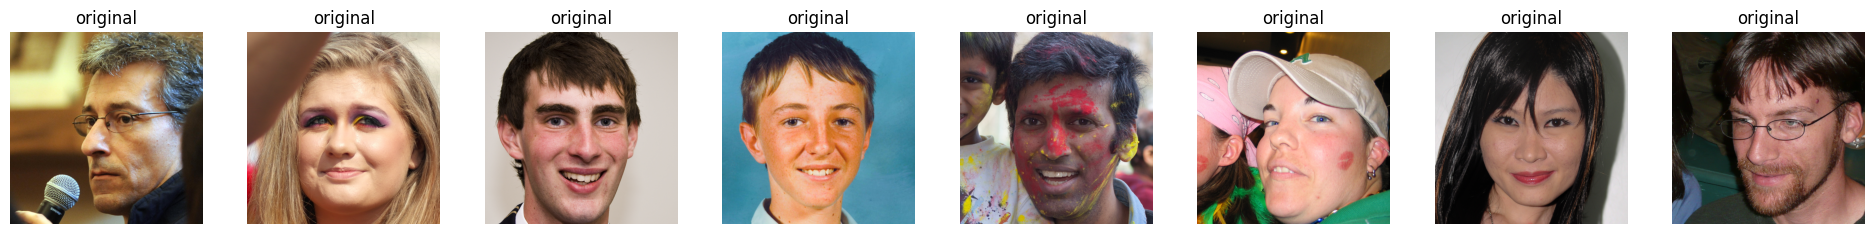

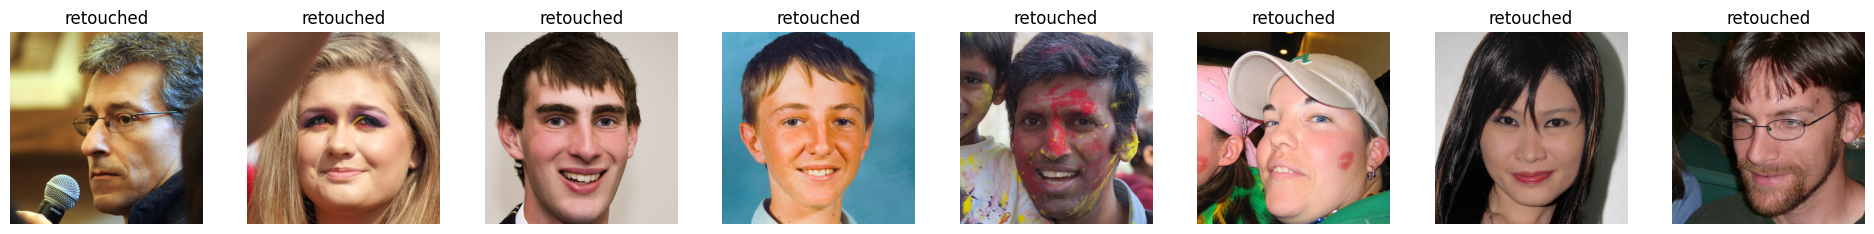

In [8]:
# Check that images loaded correctly

def imshow_batch(orig, retouch):
    orig = orig / 2 + 0.5
    orig = orig.numpy()

    batch_size = len(orig)
    _, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 2.5))
    if batch_size == 1: axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = np.transpose(orig[idx], (1, 2, 0))
        ax.imshow(img)
        ax.set_title("original")
        ax.axis('off')
    plt.show()
    
    retouch = retouch / 2 + 0.5
    retouch = retouch.numpy()
    
    batch_size = len(retouch)
    _, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 2.5))
    if batch_size == 1: axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = np.transpose(retouch[idx], (1, 2, 0))
        ax.imshow(img)
        ax.set_title("retouched")
        ax.axis('off')
    plt.show()


for images, labels in train_loader:
    imshow_batch(images, labels)
    break

## Model training

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation='relu', use_batchnorm=True):
            layers = []
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            if activation == 'relu':
                layers.append(nn.ReLU(inplace=True))
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        # Encoder (Downsampling)
        self.enc1 = block(3, 64, use_batchnorm=False, activation='leakyrelu')  # Input layer (3x1024x1024)
        self.enc2 = block(64, 128)  # 512x512
        self.enc3 = block(128, 256)  # 256x256
        self.enc4 = block(256, 512)  # 128x128
        self.enc5 = block(512, 1024)  # 64x64
        self.enc6 = block(1024, 1024)  # 32x32

        # Decoder (Upsampling)
        self.dec1 = block(1024, 1024)  # 32x32 -> 64x64
        self.dec2 = block(1024, 512)  # 64x64 -> 128x128
        self.dec3 = block(512, 256)  # 128x128 -> 256x256
        self.dec4 = block(256, 128)  # 256x256 -> 512x512
        self.dec5 = block(128, 64)  # 512x512 -> 1024x1024
        self.dec6 = block(64, 32)  # Additional block for refinement at 1024x1024
        
        # Final layer (producing 3 channels for the RGB image)
        self.final_layer = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)  # Output layer to match input channel count
        
    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)  # 1024x1024 -> 512x512
        e2 = self.enc2(e1)  # 512x512 -> 256x256
        e3 = self.enc3(e2)  # 256x256 -> 128x128
        e4 = self.enc4(e3)  # 128x128 -> 64x64
        e5 = self.enc5(e4)  # 64x64 -> 32x32
        e6 = self.enc6(e5)  # 32x32 -> 16x16

        # Decoding path (make sure the upsampled tensors match the corresponding encoder dimensions)
        d1 = F.interpolate(self.dec1(e6), size=(e5.size(2), e5.size(3)), mode='bilinear', align_corners=True)  # 16x16 -> 32x32
        d2 = F.interpolate(self.dec2(d1 + e5), size=(e4.size(2), e4.size(3)), mode='bilinear', align_corners=True)  # 32x32 -> 64x64
        d3 = F.interpolate(self.dec3(d2 + e4), size=(e3.size(2), e3.size(3)), mode='bilinear', align_corners=True)  # 64x64 -> 128x128
        d4 = F.interpolate(self.dec4(d3 + e3), size=(e2.size(2), e2.size(3)), mode='bilinear', align_corners=True)  # 128x128 -> 256x256
        d5 = F.interpolate(self.dec5(d4 + e2), size=(e1.size(2), e1.size(3)), mode='bilinear', align_corners=True)  # 256x256 -> 512x512
        d6 = F.interpolate(self.dec6(d5 + e1), size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)  # 512x512 -> 1024x1024

        # Final output layer (skip connection from e1 and final output)
        output = torch.tanh(self.final_layer(d6))  # 1024x1024 output
        return output


In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super(PatchDiscriminator, self).__init__()
        
        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, use_batchnorm=True):
            layers = []
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        # The discriminator architecture
        self.disc = nn.Sequential(
            block(6, 64, use_batchnorm=False),  # 6 channels = input + output images
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Patch-level output
        )
    
    def forward(self, input_image, generated_image):
        # Concatenate input and generated images along the channel axis
        x = torch.cat([input_image, generated_image], dim=1)
        return self.disc(x)


In [11]:
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

In [12]:
# custom weights initialization called on generator and discriminator
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)
 
    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [13]:
import torch.optim as optim

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.device_count())
generator = UNetGenerator().cuda().float()
discriminator = PatchDiscriminator().cuda().float()
init_weights(generator, 'normal', scaling=0.02)
init_weights(discriminator, 'normal', scaling=0.02)
generator = torch.nn.DataParallel(generator) 
discriminator = torch.nn.DataParallel(discriminator) 

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

2
initialize network with normal
initialize network with normal


In [16]:
import torch
from tqdm import tqdm  # Add tqdm for progress bars

num_epochs = 100
lambda_l1 = 100  # L1 loss weight

for epoch in range(num_epochs):
    # Initialize tqdm for progress tracking within each epoch
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch}/{num_epochs}]")
    
    for i, (input_image, real_image) in progress_bar:  # Use a DataLoader
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        input_image = input_image.to(device)
        real_image = real_image.to(device)
        
        # Total discriminator loss
        output_size = discriminator(input_image, real_image).size()
        valid = torch.ones(output_size, requires_grad=False).to(device)
        fake = torch.zeros(output_size, requires_grad=False).to(device)

        # Generate image
        generated_image = generator(input_image)

        # Discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(input_image, real_image), valid)
        fake_loss = adversarial_loss(discriminator(input_image, generated_image.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        
        optimizer_G.zero_grad()
        
        # Adversarial loss
        g_adv_loss = adversarial_loss(discriminator(input_image, generated_image), valid)
        
        # L1 loss
        g_l1_loss = l1_loss(generated_image, real_image) * lambda_l1
        
        # Total generator loss
        g_loss = g_adv_loss + g_l1_loss
        
        g_loss.backward()
        optimizer_G.step()
        
        # Update tqdm progress bar with current losses
        progress_bar.set_postfix({
            'D Loss': f"{d_loss.item():.4f}", 
            'G Loss': f"{g_loss.item():.4f}"
        })
        
    # Optionally print summary of the epoch (or rely on tqdm progress bar updates)
    print(f"Epoch [{epoch}/{num_epochs}] completed | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [0/100]: 100%|██████████| 200/200 [09:04<00:00,  2.72s/it, D Loss=0.7414, G Loss=12.2484]


Epoch [0/100] completed | D Loss: 0.7414 | G Loss: 12.2484


Epoch [1/100]: 100%|██████████| 200/200 [08:10<00:00,  2.45s/it, D Loss=0.1718, G Loss=10.0422]


Epoch [1/100] completed | D Loss: 0.1718 | G Loss: 10.0422


Epoch [2/100]: 100%|██████████| 200/200 [08:17<00:00,  2.49s/it, D Loss=0.0477, G Loss=11.7197]


Epoch [2/100] completed | D Loss: 0.0477 | G Loss: 11.7197


Epoch [3/100]: 100%|██████████| 200/200 [08:15<00:00,  2.48s/it, D Loss=0.0786, G Loss=10.6425]


Epoch [3/100] completed | D Loss: 0.0786 | G Loss: 10.6425


Epoch [4/100]: 100%|██████████| 200/200 [08:16<00:00,  2.48s/it, D Loss=0.1097, G Loss=10.8177]


Epoch [4/100] completed | D Loss: 0.1097 | G Loss: 10.8177


Epoch [5/100]: 100%|██████████| 200/200 [08:16<00:00,  2.48s/it, D Loss=0.4848, G Loss=6.6334] 


Epoch [5/100] completed | D Loss: 0.4848 | G Loss: 6.6334


Epoch [6/100]: 100%|██████████| 200/200 [08:16<00:00,  2.48s/it, D Loss=0.4631, G Loss=8.9970] 


Epoch [6/100] completed | D Loss: 0.4631 | G Loss: 8.9970


Epoch [7/100]:  90%|█████████ | 180/200 [07:28<00:49,  2.49s/it, D Loss=0.0381, G Loss=8.0579] 


KeyboardInterrupt: 